# **Problem No 22**

### **Objective:**
Given a multiband image of N bands, compute principal components and generate the approximate version of the input image by performing inverse principal component transform using 2, 3, ..., N-1 components.

---

### **Team Members:**
- **Aminur Hossain** (ID: 24D1384)
- **Amartya Ray** (ID: 24D1383)

---

### **Input Data:**
- **Dataset:** Landsat-8 satellite image
- **Bands:** 7 bands (for the Mumbai Scene)

---

### **Steps to Solve the Problem:**
1. **Load the Multiband Image:**
   - Import the Landsat-8 image with 7 bands for the Mumbai scene.
   
2. **Compute Principal Components (PCA):**
   - Perform Principal Component Analysis (PCA) on the 7-band image to reduce dimensionality.

3. **Reconstruction Using 2, 3, ..., N-1 Principal Components:**
   - Reconstruct the image using inverse PCA with 2, 3, 4, 5, and 6 components to generate approximate images.

4. **Comparison:**
   - Compare the quality of reconstructed images using various quality metrics such as PSNR and SSIM to evaluate how much detail is retained with fewer components.

5. **Visualization:**
   - Display the original image alongside the reconstructed versions with different numbers of components for a visual comparison.

---

### **Expected Results:**
- Images reconstructed using varying numbers of components will show a trade-off between reduced complexity (lower number of components) and image quality (higher number of components).
- Evaluate which number of components gives the best balance between compression and quality retention.


In [13]:
#!pip install rasterio
import numpy as np
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

In [14]:
# Data preprocessing
def read_multiband_image(file_path):
    with rasterio.open(file_path) as src:
        bands = src.read()
        meta = src.meta
    return bands, meta

def write_image(file_path, image, meta):
    with rasterio.open(file_path, 'w', **meta) as dest:
        dest.write(image)

def normalize_data(bands):
    # Reshape bands to (num_bands, height * width)
    num_bands, height, width = bands.shape
    reshaped_bands = bands.reshape(num_bands, height * width)

    # Standardize each band
    mean = reshaped_bands.mean(axis=1, keepdims=True)
    std = reshaped_bands.std(axis=1, keepdims=True)
    normalized_bands = (reshaped_bands - mean) / std

    return normalized_bands.reshape(num_bands, height, width), mean, std


In [15]:
def perform_pca(bands):
    num_bands, height, width = bands.shape
    reshaped_bands = bands.reshape(num_bands, height * width).T

    # Compute covariance matrix
    covariance_matrix = np.cov(reshaped_bands, rowvar=False)

    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

    # Sort eigenvalues and eigenvectors in descending order
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]

    # Project the data onto the eigenvectors
    principal_components = np.dot(reshaped_bands, eigenvectors)

    return eigenvectors, principal_components, (num_bands, height, width), eigenvalues


In [16]:
def inverse_pca_and_reconstruct(eigenvectors, principal_components, shape, num_components, mean, std):
    # Select the top num_components eigenvectors
    selected_eigenvectors = eigenvectors[:, :num_components]

    # Select the corresponding principal components
    selected_components = principal_components[:, :num_components]

    # Reconstruct the image
    reconstructed = np.dot(selected_components, selected_eigenvectors.T)
    reconstructed = reconstructed.T

    # De-normalize the reconstructed data
    num_bands, height, width = shape
    reconstructed = reconstructed.reshape(num_bands, height * width)
    reconstructed = (reconstructed * std) + mean
    reconstructed = reconstructed.reshape(num_bands, height, width)

    return reconstructed

In [17]:
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim

# Function to calculate PSNR
def calculate_psnr(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if mse == 0:  # MSE is zero means no noise is present in the signal, PSNR is infinite
        return float('inf')
    max_pixel = 65536.0
    psnr_value = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr_value

# Function to calculate SSIM
def calculate_ssim(original, compressed):
    ssim_value = ssim(original, compressed, multichannel=True, data_range=65536)
    return ssim_value

Reconstructed image with 2 components saved to reconstructed_with_2_components.dat


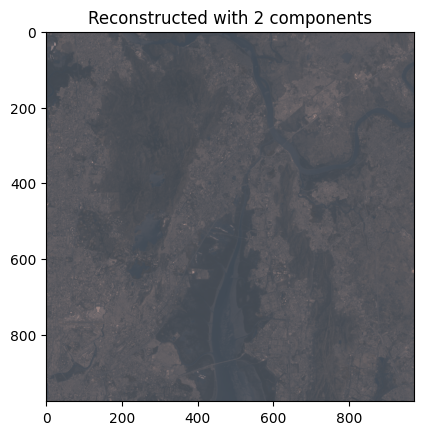

Reconstructed image with 3 components saved to reconstructed_with_3_components.dat


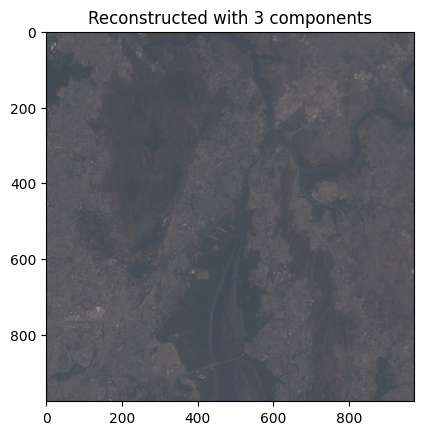

Reconstructed image with 4 components saved to reconstructed_with_4_components.dat


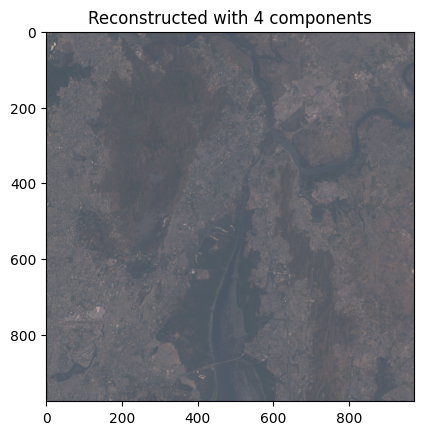

Reconstructed image with 5 components saved to reconstructed_with_5_components.dat


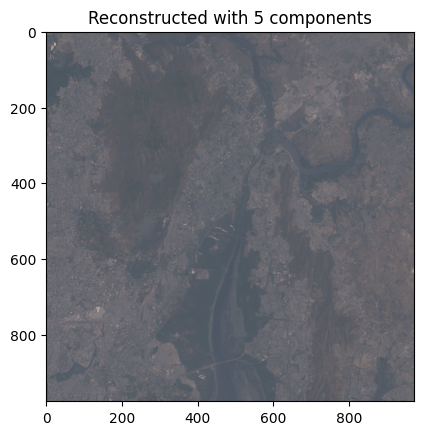

Reconstructed image with 6 components saved to reconstructed_with_6_components.dat


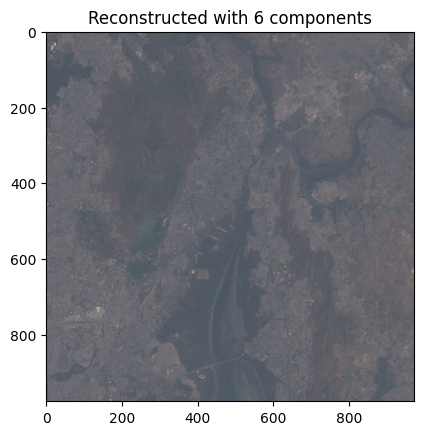

In [18]:
def main(image_file_path):
    reconstructed_list = []
    bands, meta = read_multiband_image(file_path)
    normalize_bands, mean, std = normalize_data(bands)
    eigenvectors, principal_components, shape, eigenvalues = perform_pca(normalize_bands)

    for num_components in range(2, bands.shape[0]):
        reconstructed_image = inverse_pca_and_reconstruct(eigenvectors, principal_components, shape, num_components, mean, std)
        output_path = f'reconstructed_with_{num_components}_components.dat'
        reconstructed_list.append(reconstructed_image)
        # Image quality parameters
        # psnr_value = calculate_psnr(reconstructed_image, bands)
        # ssim_value = calculate_ssim(reconstructed_image, bands)
        # print(f'PSNR for {num_components} components: {psnr_value}')
        # print(f'SSIM for {num_components} components: {ssim_value}')
        # Update metadata for writing
        meta.update(dtype=rasterio.float32, count=reconstructed_image.shape[0])

        write_image(output_path, reconstructed_image, meta)
        print(f'Reconstructed image with {num_components} components saved to {output_path}')

        # Display the reconstructed image using RGB bands (4, 3, 2)
        rgb_image = reconstructed_image[[3, 2, 1], :, :]  # Bands 4, 3, 2 are at indices 3, 2, 1

        # rgb_image = np.clip(rgb_image, 0, 255).astype(np.uint8)
        # print(rgb_image.max())
        plt.imshow(np.transpose(rgb_image/np.max(rgb_image), (1, 2, 0))) # for visualization only
        plt.title(f'Reconstructed with {num_components} components')
        plt.show()
    return reconstructed_list

if __name__ == '__main__':
    file_path = 'pca_22_input.dat'
    reconstructed_list = main(file_path)


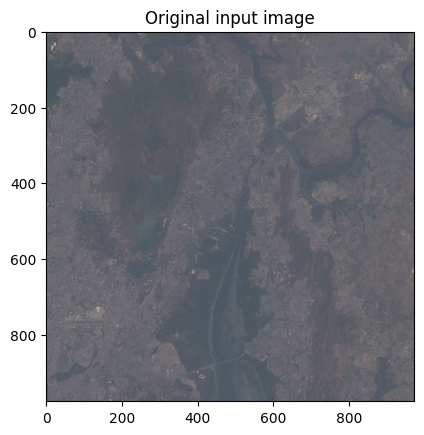

In [19]:
#Showing input image
file_path = 'pca_22_input.dat'
bands, meta = read_multiband_image(file_path)
input_rgb_image = bands[[3, 2, 1], :, :]  # Bands 4, 3, 2 are at indices 3, 2, 1
# rgb_image = np.clip(rgb_image, 0, 255).astype(np.uint8)
plt.imshow(np.transpose(input_rgb_image/np.max(input_rgb_image), (1, 2, 0))) # for visualization only
plt.title(f'Original input image')
plt.show()

Sorted Eigenvaluee for COV matrxi [5.03603319e+00 1.44939122e+00 4.27380022e-01 6.29350374e-02
 1.19149112e-02 8.92301899e-03 3.42997854e-03]
Reconstructed image with 7 components saved to reconstructed_with_7_components.dat


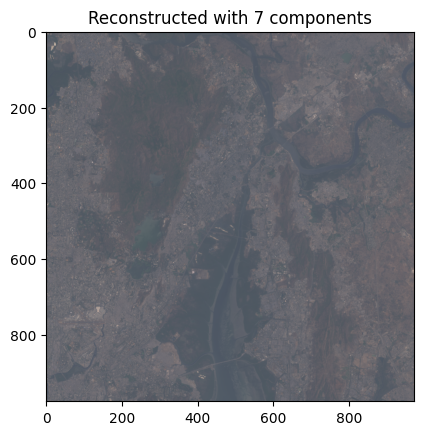

In [20]:
bands, meta = read_multiband_image(file_path)
normalize_bands, mean, std = normalize_data(bands)
eigenvectors, principal_components, shape, eigenvalues = perform_pca(normalize_bands)
print(f'Sorted Eigenvaluee for COV matrxi', eigenvalues)


num_components = 7
reconstructed_image = inverse_pca_and_reconstruct(eigenvectors, principal_components, shape, num_components,mean, std)
output_path = f'reconstructed_with_{num_components}_components.dat'

# Update metadata for writing
meta.update(dtype=rasterio.float32, count=reconstructed_image.shape[0])

write_image(output_path, reconstructed_image, meta)
print(f'Reconstructed image with {num_components} components saved to {output_path}')

# Display the reconstructed image using RGB bands (4, 3, 2)
rgb_image = reconstructed_image[[3, 2, 1], :, :]  # Bands 4, 3, 2 are at indices 3, 2, 1
# rgb_image = np.clip(rgb_image, 0, 255).astype(np.uint8)
plt.imshow(np.transpose(rgb_image/np.max(rgb_image), (1, 2, 0))) # for visualization only
plt.title(f'Reconstructed with {num_components} components')
plt.show()

In [21]:
np.max(np.float32(reconstructed_image)-np.float32(bands))

0.0

In [22]:
#Two images are exactly same if output is True
np.array_equal(np.float32(reconstructed_image), np.float32(bands))

True

In [23]:
import numpy as np
import pandas as pd

# Example eigenvalue array for the 7 bands (you can replace this with actual eigenvalues)
# Function to calculate cumulative explained variance for different number of bands
def calculate_variation_percentage(eigenvalues, components):
    total_variance = np.sum(eigenvalues)
    variance_captured = np.sum(eigenvalues[:components])
    percentage_variation = (variance_captured / total_variance) * 100
    return percentage_variation

# Number of components to calculate the variation percentages for
components_list = [2, 3, 4, 5, 6]

# Create a dictionary to store the results
results = {"Number of Components": [], "Explained Variance (%)": [], "PSNR Value": [], "SSIM Value": []}

# Calculate variation percentage for each number of components
for ind, components in enumerate(components_list):
    explained_variance = calculate_variation_percentage(eigenvalues, components)
    psnr_value = calculate_psnr(reconstructed_list[ind], bands)
    ssim_value = calculate_ssim(reconstructed_list[ind], bands)
    results["Number of Components"].append(components)
    results["Explained Variance (%)"].append(explained_variance)
    results["PSNR Value"].append(psnr_value)
    results["SSIM Value"].append(ssim_value)
# Convert the results to a pandas DataFrame
df = pd.DataFrame(results)
# Print the table
print(df)

   Number of Components  Explained Variance (%)  PSNR Value  SSIM Value
0                     2               92.648822   42.265273    0.974810
1                     3               98.754245   53.182213    0.997816
2                     4               99.653316   56.422082    0.999007
3                     5               99.823529   64.123555    0.999828
4                     6               99.951000   73.585176    0.999979
